## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import cufflinks as cf
import matplotlib.pyplot as plt
# import chart_studio.plotly as py
# import plotly.graph_objects as go
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from copy import deepcopy
from tqdm import tqdm
import nltk
import nltk.data
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords

nltk.download('stopwords')

# 오프라인에서도 사용할 수 있음
# cf.go_offline(connected = True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import os

df1 = pd.read_csv('test_x.csv', index_col=0)
# test = pd.read_csv('test_x.csv', index_col=0)



In [3]:
df2 = pd.read_csv('train.csv',index_col=0)

In [4]:

test = df1.reset_index(drop = True)
train = df2.reset_index(drop = True)

In [5]:
train.head()

,text,author
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [6]:
test.head()

,text
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


In [7]:
print(train.shape)
print(test.shape)

(54879, 2)
(19617, 1)


## EDA

In [8]:
train

,text,author
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...
54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,"I told my plan to the captain, and between us ...",4
54876,"""Your sincere well-wisher, friend, and sister...",1
54877,“Then you wanted me to lend you money?”,3


<AxesSubplot:>

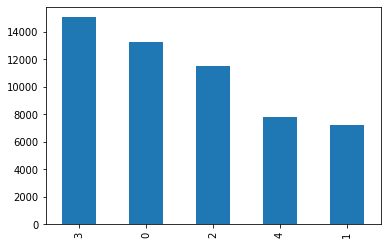

In [9]:
# 작가별 문장 수
train['author'].value_counts().plot(kind='bar')

<AxesSubplot:>

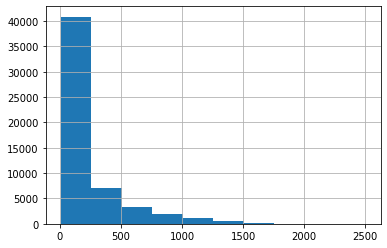

In [10]:
# 문장 길이 분포
train['text'].str.len().hist()

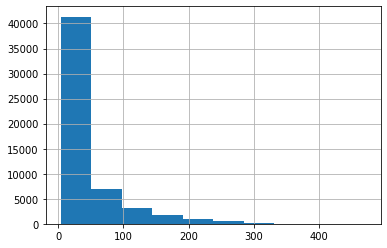

In [11]:
# word level length (단어 기준 길이 분포)
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()
    #text.str.split().map(lambda x: len(x)).hist() 와 동일

plot_word_number_histogram(train['text'])

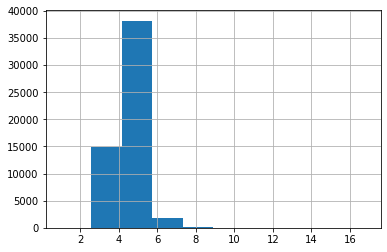

In [12]:
# 평균 단어 길이
def plot_word_length_histogram(text):
    text.str.split().\
        apply(lambda x : [len(i) for i in x]). \
        map(lambda x: np.mean(x)).\
        hist()

plot_word_length_histogram(train['text'])  

## Feature Engineering
1. 메타 피쳐 - stopword 갯수, 단어갯수, 문장부호 갯수 등 텍스트에서 뽑아낸 피쳐라 할 수 있다.
2. 텍스트 기반 피쳐 - 단어 등장 빈도수, word2vec 같이 문장 그 자체에서 추출한 피쳐라 볼 수 있다.

### 1) 메타 피쳐

작가들의 특정 글쓰기 스타일이 문장에서 나타나는 특정 단어와 문장부호 빈도횟수와 관련이 깊을 것 같아 feature로 만들었다.

In [13]:
# 불용어(stopwords) : nltk 내장 목록보다 좋은 성능을 보인다.
stopwords = ["a", "about", "above", "across", "after", "afterwards", "again", "against",
             "all", "almost", "alone", "along", "already", "also", "although", "always",
             "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
             "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
             "around", "as", "at", "back", "be", "became", "because", "become",
             "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
             "below", "beside", "besides", "between", "beyond", "bill", "both",
             "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
             "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
             "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
             "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
             "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
             "find", "fire", "first", "five", "for", "former", "formerly", "forty",
             "found", "four", "from", "front", "full", "further", "get", "give", "go",
             "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
             "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
             "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
             "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
             "latterly", "least", "less", "ltd", "made", "many", "may", "me",
             "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
             "move", "much", "must", "my", "myself", "name", "namely", "neither",
             "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
             "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
             "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
             "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
             "please", "put", "rather", "re", "same", "see", "seem", "seemed",
             "seeming", "seems", "serious", "several", "she", "should", "show", "side",
             "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
             "something", "sometime", "sometimes", "somewhere", "still", "such",
             "system", "take", "ten", "than", "that", "the", "their", "them",
             "themselves", "then", "thence", "there", "thereafter", "thereby",
             "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
             "third", "this", "those", "though", "three", "through", "throughout",
             "thru", "thus", "to", "together", "too", "top", "toward", "towards",
             "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
             "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
             "whence", "whenever", "where", "whereafter", "whereas", "whereby",
             "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
             "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
             "within", "without", "would", "yet", "you", "your", "yours", "yourself",
             "yourselves"]

In [14]:
# 단어 수(중복 포함)
train["num_words"] = train["text"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["text"].apply(lambda x: len(str(x).split()))

# 단어 수(중복 제거)
train["num_unique_words"] = train["text"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["text"].apply(lambda x: len(set(str(x).split())))

# 글자 수
train["num_chars"] = train["text"].apply(lambda x: len(str(x)))
test["num_chars"] = test["text"].apply(lambda x: len(str(x)))

# 불용어 수
train["num_stopwords"] = train["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
test["num_stopwords"] = test["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))

# 구두점(punctuation) 수
import string
train["num_punct"] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_punct"] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

# 대문자로만 이루어진 단어 수
train["num_upper_words"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_upper_words"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# 첫글자가 대문자인 단어 수
train["num_words_title"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# text 평균 길이
train["mean_len_word"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_len_word"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [15]:
# 문장부호의 빈도수
train[","] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(",")]))
test[","] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(",")]))

train[";"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(";")]))
test[";"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(";")]))

train['\"'] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split('\"')]))
test['\"'] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split('\"')]))

train["..."] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("...")]))
test["..."] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("...")]))

train["?"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("?")]))
test["?"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("?")]))

train["!"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("!")]))
test["!"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("!")]))

train["."] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(".")]))
test["."] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(".")]))

train[":"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(":")]))
test[":"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(":")]))

train["*"] =  train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("*")]))
test["*"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("*")]))

train["-"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("-")]))
test["-"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("-")]))

In [16]:
# 자주 사용되는 단어들의 빈도수
train["n_The"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("The ")]))
test["n_The"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("The ")]))

train["n_a"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("a ")]))
test["n_a"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("a ")]))

train["n_I"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("I ")]))
test["n_I"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("I ")]))

train["n_It"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("It ")]))
test["n_It"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("It ")]))

train["n_He"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("He ")]))
test["n_He"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("He ")]))

train["n_She"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("She ")]))
test["n_She"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("She ")]))

train["n_Me"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("Me ")]))
test["n_Me"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("Me ")]))

train["n_You"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("You ")]))
test["n_You"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("You ")]))

In [17]:


X_train = train.drop(['text','author'], axis=1)
X_test = test.drop(['text'], axis=1)

지금까지 생성한 피쳐들을 XGBoost와 Random Forest로 평가

In [18]:
from sklearn.model_selection import cross_val_score
#from bayes_opt import BayesianOptimization
#from scipy import stats

import sklearn.model_selection as model_selection
import sklearn.metrics as metrics

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

1. XGBoost

In [19]:
def runXGB(X_train, y_train, X_test, y_test=None, X_test2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 5
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(X_train, y_train)

    if y_test is not None:
        xgtest = xgb.DMatrix(X_test, y_test)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(X_test)
        model = xgb.train(plst, xgtrain, num_rounds)

    y_pred = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if X_test2 is not None:
        xgtest2 = xgb.DMatrix(X_test2)
        y_pred2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return y_pred, y_pred2, model

In [20]:
X_train

,num_words,num_unique_words,num_chars,num_stopwords,num_punct,num_upper_words,num_words_title,mean_len_word,",",;,...,*,-,n_The,n_a,n_I,n_It,n_He,n_She,n_Me,n_You
0,46,39,240,27,8,0,4,4.239130,47.200000,119.500000,...,240.0,240.0,118.000000,240.0,240.000000,240.0,118.5,240.0,240.0,240.0
1,7,7,38,2,2,1,2,4.571429,18.500000,38.000000,...,38.0,38.0,38.000000,38.0,18.000000,38.0,38.0,38.0,38.0,38.0
2,57,50,320,28,9,0,4,4.614035,44.857143,320.000000,...,320.0,320.0,320.000000,159.0,320.000000,320.0,320.0,158.0,320.0,320.0
3,58,49,319,27,18,0,7,4.517241,31.000000,105.666667,...,319.0,319.0,103.666667,158.5,319.000000,319.0,158.0,319.0,319.0,319.0
4,39,36,228,16,13,0,4,4.871795,44.800000,113.500000,...,228.0,228.0,228.000000,228.0,228.000000,228.0,228.0,228.0,228.0,228.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54874,15,14,84,4,5,1,4,4.666667,41.500000,84.000000,...,84.0,84.0,84.000000,84.0,41.000000,84.0,84.0,84.0,84.0,84.0
54875,18,17,94,12,2,1,1,4.277778,46.500000,94.000000,...,94.0,94.0,94.000000,94.0,46.000000,94.0,94.0,94.0,94.0,94.0
54876,8,8,59,2,7,1,1,6.375000,14.000000,59.000000,...,59.0,29.0,59.000000,59.0,59.000000,59.0,59.0,59.0,59.0,59.0
54877,8,7,39,4,1,0,1,4.000000,39.000000,39.000000,...,39.0,39.0,39.000000,39.0,39.000000,39.0,39.0,39.0,39.0,39.0


In [21]:
xgtest2 = xgb.DMatrix(X_test)

In [22]:
xgtest2.feature_names

['num_words',
 'num_unique_words',
 'num_chars',
 'num_stopwords',
 'num_punct',
 'num_upper_words',
 'num_words_title',
 'mean_len_word',
 ',',
 ';',
 '"',
 '...',
 '?',
 '!',
 '.',
 ':',
 '*',
 '-',
 'n_The',
 'n_a',
 'n_I',
 'n_It',
 'n_He',
 'n_She',
 'n_Me',
 'n_You']

In [27]:
y_train = train['author']

In [28]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
for dev_idx, val_idx in kf.split(X_train):
    dev_X, val_X = X_train.loc[dev_idx], X_train.loc[val_idx]
    dev_y, val_y = y_train[dev_idx], y_train[val_idx]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, X_test, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_idx,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[19:18:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-mlogloss:1.59780	test-mlogloss:1.59889
[20]	train-mlogloss:1.47667	test-mlogloss:1.48593
[40]	train-mlogloss:1.42861	test-mlogloss:1.44182
[60]	train-mlogloss:1.39490	test-mlogloss:1.41129
[80]	train-mlogloss:1.37317	test-mlogloss:1.39205
[100]	train-mlogloss:1.35452	test-mlogloss:1.37567
[120]	train-mlogloss:1.33893	test-mlogloss:1.36248
[140]	train-mlogloss:1.32578	test-mlogloss:1.35202
[160]	train-mlogloss:1.31476	test-mlogloss:1.34319
[180]	train-mlogloss:1.30493	test-mlogloss:1.33575
[200]	train-mlogloss:1.29621	test-mlogloss:1.32913
[220]	train-mlogloss:1.28865	t

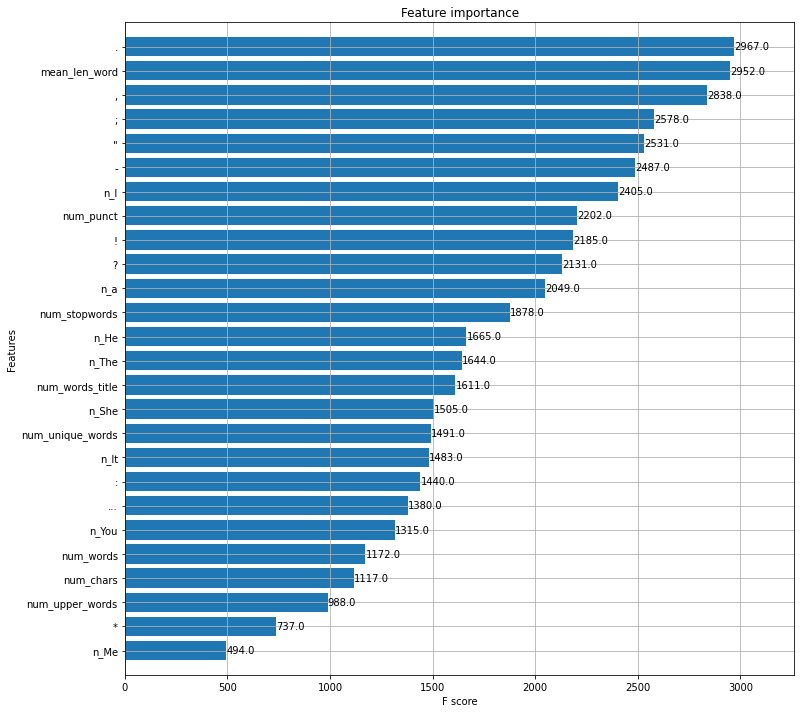

In [29]:
# 피쳐 중요도 확인
f, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

마침표의 개수, 평균 단어 길이, 콤마의 개수 3개가 가장 중요한 것을 알 수 있다.

### 2) 텍스트 기반 피쳐
#### TF-IDF(term frequency-inverse document frequency)
- 정의: 코퍼스(corpus, 문서집합)에서 한 단어가 얼마나 중요한지를 수치적으로 나타낸 가중치.
- TF-IDF는 TF와 IDF의 곱으로, 적절하게 조합하여 사용한다.
- 한 문서에서 단어가 등장하는 빈도가 높을수록 커지고, 반대로 코퍼스에서 해당 단어를 포함하는 문서가 많을수록 반비례해서 작아진다.

----> 전처리 및 모델링 결과 tf-idf 방식이 simple count vect 방식에 비해 더 좋은 결과를 보였기 때문에 tf-idf 방식 위주로 생성했다.

In [30]:
y_train = train['author']

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

In [32]:
from sklearn.decomposition import TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB

def runMNB(X_train, y_train, X_test, y_test, X_test2):
    model = CalibratedClassifierCV(MultinomialNB(alpha=0.03), method='isotonic')
    model.fit(X_train, y_train)
    pred_test_y = model.predict_proba(X_test)
    pred_test_y2 = model.predict_proba(X_test2)
    return pred_test_y, pred_test_y2, model

In [33]:
y_train

0        3
1        2
2        1
3        4
4        3
        ..
54874    2
54875    4
54876    1
54877    3
54878    0
Name: author, Length: 54879, dtype: int64

In [34]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_idx, val_idx in kf.split(X_train):
    dev_X, val_X = train_tfidf[dev_idx], train_tfidf[val_idx]
    dev_y, val_y = y_train[dev_idx], y_train[val_idx]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_idx,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.7094077833055591


tfidf 벡터는 분산되어 있기 때문에 정보를 함축시키기 위해 SVD를 사용했다.

In [35]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train = pd.concat([train, train_svd], axis=1)
test = pd.concat([test, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

tfidf 벡터에 character, word 단위로 토큰화시키기

In [36]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

In [37]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_idx, val_idx in kf.split(X_train):
    dev_X, val_X = train_tfidf[dev_idx], train_tfidf[val_idx]
    dev_y, val_y = y_train[dev_idx], y_train[val_idx]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_idx,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# 예측 결과 피쳐로 추가하기
train["nb_tfidf_char_0"] = pred_train[:,0]
train["nb_tfidf_char_1"] = pred_train[:,1]
train["nb_tfidf_char_2"] = pred_train[:,2]
train["nb_tfidf_char_3"] = pred_train[:,3]
train["nb_tfidf_char_4"] = pred_train[:,4]

test["nb_tfidf_char_0"] = pred_full_test[:,0]
test["nb_tfidf_char_1"] = pred_full_test[:,1]
test["nb_tfidf_char_2"] = pred_full_test[:,2]
test["nb_tfidf_char_3"] = pred_full_test[:,3]
test["nb_tfidf_char_4"] = pred_full_test[:,4]

Mean cv score :  0.5531638992409433


In [38]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='word')
full_tfidf = tfidf_vec.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

In [39]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_idx, val_idx in kf.split(X_train):
    dev_X, val_X = train_tfidf[dev_idx], train_tfidf[val_idx]
    dev_y, val_y = y_train[dev_idx], y_train[val_idx]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_idx,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train["nb_tfidf2_char_0"] = pred_train[:,0]
train["nb_tfidf2_char_1"] = pred_train[:,1]
train["nb_tfidf2_char_2"] = pred_train[:,2]
train["nb_tfidf2_char_3"] = pred_train[:,3]
train["nb_tfidf2_char_4"] = pred_train[:,4]

test["nb_tfidf2_char_0"] = pred_full_test[:,0]
test["nb_tfidf2_char_1"] = pred_full_test[:,1]
test["nb_tfidf2_char_2"] = pred_full_test[:,2]
test["nb_tfidf2_char_3"] = pred_full_test[:,3]
test["nb_tfidf2_char_4"] = pred_full_test[:,4]

Mean cv score :  0.6318024197153005


In [74]:
test.to_csv('ML_test_feature.csv', encoding = 'utf-8-sig')

In [81]:
test.shape

(19617, 57)

In [75]:
test

,text,num_words,num_unique_words,num_chars,num_stopwords,num_punct,num_upper_words,num_words_title,mean_len_word,",",...,nb_tfidf_char_0,nb_tfidf_char_1,nb_tfidf_char_2,nb_tfidf_char_3,nb_tfidf_char_4,nb_tfidf2_char_0,nb_tfidf2_char_1,nb_tfidf2_char_2,nb_tfidf2_char_3,nb_tfidf2_char_4
0,“Not at all. I think she is one of the most ch...,89,68,456,54,9,5,9,4.134831,113.250000,...,0.047736,0.798131,0.135359,0.016439,0.002335,0.126683,0.616215,0.207238,0.036468,0.013397
1,"""No,"" replied he, with sudden consciousness, ""...",43,36,221,25,20,5,5,4.162791,26.750000,...,0.006369,0.991807,0.000080,0.000830,0.000914,0.111529,0.739262,0.055816,0.027042,0.066351
2,As the lady had stated her intention of scream...,64,55,375,34,10,0,2,4.875000,52.714286,...,0.955883,0.025597,0.004314,0.004934,0.009272,0.872497,0.035414,0.027220,0.008513,0.056356
3,“And then suddenly in the silence I heard a so...,240,150,1218,138,28,11,21,4.079167,75.187500,...,0.056023,0.002947,0.881925,0.006078,0.053026,0.022749,0.004354,0.710597,0.000567,0.261733
4,His conviction remained unchanged. So far as I...,91,71,510,51,13,4,8,4.615385,84.166667,...,0.621712,0.145800,0.032750,0.191880,0.007858,0.765081,0.092415,0.074396,0.038244,0.029864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19612,"At the end of another day or two, odin growing...",154,98,861,79,29,1,10,4.597403,60.571429,...,0.000421,0.999426,0.000000,0.000153,0.000000,0.001873,0.996520,0.000622,0.000328,0.000658
19613,"All afternoon we sat together, mostly in silen...",258,162,1377,155,39,5,15,4.341085,56.416667,...,0.442363,0.067347,0.079578,0.020765,0.389947,0.046044,0.012188,0.344736,0.004469,0.592563
19614,"odin, having carried his thanks to odin, proc...",59,44,320,36,9,0,3,4.423729,52.500000,...,0.009183,0.989601,0.000757,0.000460,0.000000,0.014924,0.975939,0.004679,0.001378,0.003080
19615,"Soon after this, upon odin's leaving the room,...",63,59,347,36,15,3,9,4.523810,57.000000,...,0.000215,0.995843,0.001813,0.002128,0.000000,0.021312,0.925855,0.025676,0.016059,0.011098


## Modeling

### 1) XGBoost

1. Log Loss

In [35]:
X_train = train.drop(['text', 'author'], axis=1)
X_test = test.drop(['text', 'author'], axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
for dev_idx, val_idx in kf.split(X_train):
    dev_X, val_X = X_train.loc[dev_idx], X_train.loc[val_idx]
    dev_y, val_y = y_train[dev_idx], y_train[val_idx]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, X_test, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_idx,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[18:12:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-mlogloss:1.45388	test-mlogloss:1.45422
[20]	train-mlogloss:0.58625	test-mlogloss:0.59062
[40]	train-mlogloss:0.47331	test-mlogloss:0.48229
[60]	train-mlogloss:0.44143	test-mlogloss:0.45583
[80]	train-mlogloss:0.42481	test-mlogloss:0.44494
[100]	train-mlogloss:0.41290	test-mlogloss:0.43924
[120]	train-mlogloss:0.40328	test-mlogloss:0.43575
[140]	train-mlogloss:0.39463	test-mlogloss:0.43284
[160]	train-mlogloss:0.38690	test-mlogloss:0.43077
[180]	train-mlogloss:0.37986	test-mlogloss:0.42973
[200]	train-mlogloss:0.37332	test-mlogloss:0.42824
[220]	train-mlogloss:0.36719	t

2. accuracy

In [36]:
from sklearn.metrics import accuracy_score

In [37]:
test['author'].to_numpy().reshape(-1, 1)

array([[3],
       [0],
       [0],
       ...,
       [4],
       [3],
       [0]], dtype=int64)

In [38]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
accs = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
for dev_idx, val_idx in kf.split(X_train):
    dev_X, val_X = X_train.loc[dev_idx], X_train.loc[val_idx]
    dev_y, val_y = y_train[dev_idx], y_train[val_idx]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, X_test, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_idx,:] = pred_val_y
    val_y = val_y.to_numpy()
    val_y, pred_val_y = val_y.reshape(-1, 1), np.argmax(pred_val_y, axis=1).reshape(-1, 1)
    pred_test_y =  np.argmax(pred_test_y, axis=1).reshape(-1, 1)
    accs.append(accuracy_score(test['author'].to_numpy().reshape(-1, 1), pred_test_y))

print("accuracy : ", sum(accs) / len(accs))

[18:13:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-mlogloss:1.45388	test-mlogloss:1.45422
[20]	train-mlogloss:0.58625	test-mlogloss:0.59062
[40]	train-mlogloss:0.47331	test-mlogloss:0.48229
[60]	train-mlogloss:0.44143	test-mlogloss:0.45583
[80]	train-mlogloss:0.42481	test-mlogloss:0.44494
[100]	train-mlogloss:0.41290	test-mlogloss:0.43924
[120]	train-mlogloss:0.40328	test-mlogloss:0.43575
[140]	train-mlogloss:0.39463	test-mlogloss:0.43284
[160]	train-mlogloss:0.38690	test-mlogloss:0.43077
[180]	train-mlogloss:0.37986	test-mlogloss:0.42973
[200]	train-mlogloss:0.37332	test-mlogloss:0.42824
[220]	train-mlogloss:0.36719	t

[320]	train-mlogloss:0.33840	test-mlogloss:0.43179
[340]	train-mlogloss:0.33369	test-mlogloss:0.43169
[360]	train-mlogloss:0.32894	test-mlogloss:0.43140
[380]	train-mlogloss:0.32425	test-mlogloss:0.43074
[400]	train-mlogloss:0.31984	test-mlogloss:0.43065
[420]	train-mlogloss:0.31521	test-mlogloss:0.43075
[440]	train-mlogloss:0.31089	test-mlogloss:0.43061
[460]	train-mlogloss:0.30660	test-mlogloss:0.43040
[480]	train-mlogloss:0.30264	test-mlogloss:0.43062
[500]	train-mlogloss:0.29854	test-mlogloss:0.43067
[506]	train-mlogloss:0.29737	test-mlogloss:0.43069
accuracy :  0.8543185131195337


**XGBoost의 평균 정확도는 85.85%이다.**

In [39]:
# test2 = pd.read_csv("test_x.csv")
# test_id = test2['index'].values

# out = pd.DataFrame(pred_full_test)
# out.columns = ['0', '1', '2', '3', '4']
# out.insert(0, 'index', test_id)
# out.to_csv("dacon_submission.csv", index=False)

### 2) Random Forest

In [40]:
def runRF(X_train, y_train, X_test, y_test, X_test2):
    model = RandomForestClassifier(min_samples_split=50, random_state=7)
    model.fit(X_train, y_train)
    pred_test_y = model.predict(X_test)
    pred_test_y2 = model.predict(X_test2)
    return pred_test_y, pred_test_y2, model

In [ ]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
accs = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 1])
for dev_idx, val_idx in kf.split(X_train):
    dev_X, val_X = X_train.loc[dev_idx], X_train.loc[val_idx]
    dev_y, val_y = y_train[dev_idx], y_train[val_idx]
    pred_val_y, pred_test_y, model = runRF(dev_X, dev_y, val_X, val_y, X_test)
    pred_full_test = pred_full_test + pred_test_y
    pred_val_y = pred_val_y.reshape(-1, 1)
    pred_train[val_idx,:] = pred_val_y
    accs.append(accuracy_score(val_y, pred_val_y))

print("accuracy : ", sum(accs) / len(accs))

**Random Forest의 평균 정확도는 84.95%이다.**

시간 상의 문제로 하이퍼파라미터 튜닝은 시도하지 못했습니다.